In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle


# GPT dataset
This is a collection of Questions and answers to gpt3.5 and 4. <br>
Each question and answer is concatenated and truncated at the 500th character to have something bigger than tinyshakespeare to train on. <br> 
You shouldn't do this in a production enviroment. <br>

In [2]:
dataset = torch.load("datasets/gpt_dataset.pt")[20:]
valset = torch.load("datasets/gpt_dataset.pt")[:20]
ctoi = pickle.load(open("datasets/gpt_ctoi.pkl", "rb"))
itoc = pickle.load(open("datasets/gpt_itoc.pkl", "rb"))
device = torch.device("cuda:0")

sequence_length = 64
vocab_size = torch.max(dataset) + 1
X = dataset.to(device)
print(X.shape)

for c in dataset[0][:50]:
    print(itoc[c.item()], end="")

torch.Size([96004, 1088])
2aéKÃf“oqěfo50лл0mK“zo40“qfâqaooLIHK“zoqěfonсссoxI

In [3]:
vocab_size

tensor(140, dtype=torch.uint8)

In [6]:
act = F.gelu
HIDDEN_SIZE = 512

class FullyConnected(nn.Module):
    def __init__(self, in_size, out_size, hidden_size=HIDDEN_SIZE):
        super(FullyConnected, self).__init__()
        self.LayerNorm = nn.LayerNorm(in_size)

        self.fc1 = nn.Linear(in_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.LayerNorm(x)
        x = act(self.fc1(x))
        x = act(self.fc2(x))
        x = self.out(x)
        return x

class MoE(nn.Module):
    def __init__(self, in_size, out_size, hidden_size=HIDDEN_SIZE, depth=4, n_experts=5):
        super(MoE, self).__init__()
        self.LayerNorm = nn.LayerNorm(in_size)

        self.fcin = nn.Linear(in_size, hidden_size)
        self.experts = nn.ModuleList([nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_experts)]) for _ in range(depth)])
        self.fcout = nn.Linear(hidden_size, out_size)

    def forward(self, x, chosen_expert=None):
        x = x.view(x.shape[0], -1)
        x = self.LayerNorm(x)
        x = act(self.fcin(x))
        choice = torch.multinomial(torch.softmax(x[:, :4], 1), 1)[:, 0]
        if chosen_expert is None: # It might be that i goth this the other way around, doesnt matter if depth and n_experts are the same
            for i in range(len(self.experts)):
                for expert in self.experts[i]:
                    x[choice == i] += act(expert(x[choice == i]))
        else:
            for i in range(len(self.experts)):
                expert = self.experts[i][chosen_expert]
                x[choice == i] += act(expert(x[choice == i]))

        x = self.fcout(x)
        return x

class Attention(nn.Module):
    def __init__(self, config):
        super(Attention, self).__init__()
        self.config = config

        self.keys = nn.Linear(config.emb_size, config.head_size)
        self.queries = nn.Linear(config.emb_size, config.head_size)
        self.values = nn.Linear(config.emb_size, config.head_size)
        self.norm = nn.LayerNorm(sequence_length*config.emb_size)

    def forward(self, x):
        x = self.norm(x.view(x.shape[0], -1)).view(x.shape[0], sequence_length, self.config.emb_size)

        k = self.keys(x)     # [Batch_size, time, head_size]
        q = self.queries(x)  # [Batch_size, time, head_size]
        v = self.values(x)   # [Batch_size, time, head_size]

        similarity = k @ q.transpose(-2, -1)/(self.config.head_size**0.5)
        similarity = torch.tril(similarity)  # [Batch_size, time, time]
        similarity[similarity == 0] = float("-inf")
        similarity = torch.softmax(similarity, dim = 1)
        attention = similarity @ v    # [Batch_size, time, head_size]
        return attention

class GPTconfig():
    pass


class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.att = nn.ModuleList([Attention(config) for _ in range(config.n_heads)])
        self.MoE = MoE(in_size=sequence_length*config.head_size*config.n_heads, out_size=sequence_length*config.emb_size, n_experts=config.n_experts)


    def forward(self, x, chosen_expert=None):  # inputs: [Batch_size, time, vocab_size]
        batch_size = x.shape[0]
        
        x = torch.cat([att(x) for att in self.att], dim=1)
        x = x.view(batch_size, self.config.head_size*self.config.n_heads*sequence_length)
        x = self.MoE(x, chosen_expert).view(x.shape[0], sequence_length, self.config.emb_size)

        return x


class Model(nn.Module):
    def __init__(self, n_experts=5):
        super(Model, self).__init__()

        config = GPTconfig()
        config.vocab_size = X.max() + 1
        config.head_size = 20
        config.emb_size = 8
        config.n_heads = 5
        config.n_blocks = 3
        config.n_experts = n_experts
        self.config = config

        self.pemb = nn.Embedding(sequence_length, config.emb_size)
        self.wemb = nn.Embedding(config.vocab_size, config.emb_size)
        self.blocks = nn.ModuleList([Block(config) for i in range(config.n_blocks)])
        self.lout = FullyConnected(in_size=sequence_length*config.emb_size, out_size=config.vocab_size)

    def forward(self, x, chosen_expert=None):
        batch_size = x.shape[0]

        # embeddings
        pemb = self.pemb(torch.arange(sequence_length).to(device)).view(1, sequence_length, self.config.emb_size) # [time, emb_size]
        wemb = self.wemb(x)        # [Batch_size, time, emb_size]

        x = wemb + pemb
        
        for block in self.blocks:
            x = x + block(x, chosen_expert=chosen_expert)
        self.std = x.std()
        x = self.lout(x)
        return x

Net = Model(n_experts=1).to(device)
lossi = []
vlossi = []
print("Millions of parameters: ", round(sum(p.numel() for p in Net.parameters() if p.requires_grad)/1000000, 2))

Millions of parameters:  14.43


In [8]:
%%time
epochs = 250
batch_size = 8
print("Percent of dataset: ", epochs*batch_size / X.shape[0])

optimizer = torch.optim.Adam(Net.parameters(), lr=3e-4)

for epoch in tqdm(range(epochs)):
    indexes = torch.randint(len(dataset), (batch_size, ))
    indexesb = torch.arange(sequence_length+1).repeat(1024).view(1024, sequence_length+1) + torch.arange(1024).view(1024, 1)

    batch = X[indexes][:, indexesb[:, :-1]].view(-1, sequence_length)
    pred = Net(batch.long().to(device))
    loss = F.cross_entropy(pred, X[indexes][:, indexesb[:, -1]].view(-1).to(device))
    lossi.append(loss.item())
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    with torch.no_grad():
        if epoch % 10 == 0:
            indexes = torch.randint(len(valset), (batch_size, ))
            indexesb = torch.arange(sequence_length+1).repeat(1024).view(1024, sequence_length+1) + torch.arange(1024).view(1024, 1)

            batch = valset[indexes][:, indexesb[:, :-1]].view(-1, sequence_length)
            pred = Net(batch.long().to(device))
            loss = F.cross_entropy(pred, valset[indexes][:, indexesb[:, -1]].view(-1).to(device))
            vlossi.append(loss.item())


Percent of dataset:  0.020832465313945253


100%|██████████| 250/250 [06:23<00:00,  1.54s/it]

Wall time: 6min 23s


In [ ]:
Net = Model(n_experts=1).to(device)
lossi = []
vlossi = []
print("Millions of parameters: ", round(sum(p.numel() for p in Net.parameters() if p.requires_grad)/1000000, 2))

In [ ]:
%%time
epochs = 250
batch_size = 8
print("Percent of dataset: ", epochs*batch_size / X.shape[0])

optimizer = torch.optim.Adam(Net.parameters(), lr=3e-4)

for epoch in tqdm(range(epochs)):
    indexes = torch.randint(len(dataset), (batch_size, ))
    indexesb = torch.arange(sequence_length+1).repeat(1024).view(1024, sequence_length+1) + torch.arange(1024).view(1024, 1)

    batch = X[indexes][:, indexesb[:, :-1]].view(-1, sequence_length)
    pred = Net(batch.long().to(device))
    loss = F.cross_entropy(pred, X[indexes][:, indexesb[:, -1]].view(-1).to(device))
    lossi.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    with torch.no_grad():
        if epoch % 10 == 0:
            indexes = torch.randint(len(valset), (batch_size, ))
            indexesb = torch.arange(sequence_length+1).repeat(1024).view(1024, sequence_length+1) + torch.arange(1024).view(1024, 1)

            batch = valset[indexes][:, indexesb[:, :-1]].view(-1, sequence_length)
            pred = Net(batch.long().to(device))
            loss = F.cross_entropy(pred, valset[indexes][:, indexesb[:, -1]].view(-1).to(device))
            vlossi.append(loss.item())


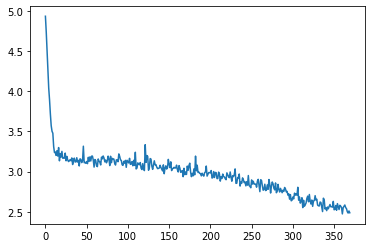

In [ ]:
plt.plot(torch.tensor(lossi[::]).view(-1, 1).mean(1))

In [ ]:
%%time 

epochs = 1000
batch_size = 4
print("Percent of dataset: ", epochs*batch_size / X.shape[0])

with torch.no_grad():
    for expert in [i for i in range(5)] + [None]:
        indexes = torch.randint(len(dataset)-sequence_length-2, (batch_size, ))
        indexesb = torch.arange(sequence_length+1).repeat(1024).view(1024, sequence_length+1) + torch.arange(1024).view(1024, 1)

        batch = X[indexes][:, indexesb[:, :-1]].view(-1, sequence_length)
        pred = Net(batch.long().to(device), chosen_expert=expert)
        loss = F.cross_entropy(pred, X[indexes][:, indexesb[:, -1]].view(-1).to(device))
    
        print("Expert: ", expert, " Loss: ", loss.item())
    

Percent of dataset:  0.04165625260351579
Expert:  0  Loss:  2.75364089012146
Expert:  1  Loss:  2.857095718383789
Expert:  2  Loss:  2.9408631324768066
Expert:  3  Loss:  2.9137661457061768
Expert:  4  Loss:  2.9295036792755127
Expert:  None  Loss:  1.5102663040161133
Wall time: 701 ms


In [ ]:
import pickle
import random
pickle.dump(Net, open(f"model-1h{random.randint(0, 100000)}.pkl", "wb"))

In [ ]:
import pickle
Net = pickle.load(open("model-1h.pkl", "rb"))
ctoi = pickle.load(open("ctoi.pkl", "rb"))
itoc = pickle.load(open("itoc.pkl", "rb"))

In [ ]:
prompt = " "*60 + "The meaning of life is... \nKI"
device = torch.device("cuda:0")
sequence_length = 64

with torch.no_grad():
    for _ in range(300):
        X = torch.tensor([ctoi[s] for s in prompt[-sequence_length:]]).long().view(1, -1).to(device)
        pred = Net.forward(X)
        prompt += itoc[torch.multinomial(F.softmax(pred, dim=1), 1).item()]
        print(prompt[-1], end="")


fo0"BToBdнZToBd¤Zс@ся@To’сo2Iff“oблK"fуo_“YлfqB–o8DлDqK0“o–fÃf“qHYo–IзлK4Dqfoqěfoзfqmff“ToD“oD“–mfHrüroб0"foqěD“o|у"0“zo50HoqěK–oDHqK–qToK“–qD“4foзI–

KeyboardInterrupt: 